### __Data Preprocessing__
In this notebook, we want to use all the features obtained in the previous step and process them to obtain an optimal dataset for analysis.

In [1]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

X = pd.read_csv('datasets/data.csv')

In [2]:
# Define two arrays to divide the parameters into two groups
flts = ['g', 'r', 'i', 'z']
pars = ['A', 'B', 't0', 't1', 'Tr', 'Tf']
# Combine the filter and parameter names - light curve parameters
lc_pars = [par+'_'+flt for par in pars for flt in flts]
# Define the array containing all the other parameters by removing lc_pars from X.columns
# For the following part, we can also remove the SNTYPE column from the other_pars array
other_pars = np.array([col for col in X.columns if (col not in lc_pars) and (col != 'SNTYPE')])

Before diving into Statistics and Machine Learning topics, we should check that the dataset does not contain unnecessary or unnecessarily complex features. To do this, we use two strategies: parameter distribution analysis and correlation matrix analysis.

#### __1. Feature Distributions__
We want to exploit the *glimpse* we get from observing parameter distributions to determine which of them can be discarded or modified.\
Starting with features that have not been extracted from the light curves, we must notice that the mere observation of histograms is not sufficient to eliminate or modify a parameter. This is because histograms have fewer bins than the number of data points, so neighbouring values may be collected in the same bin.

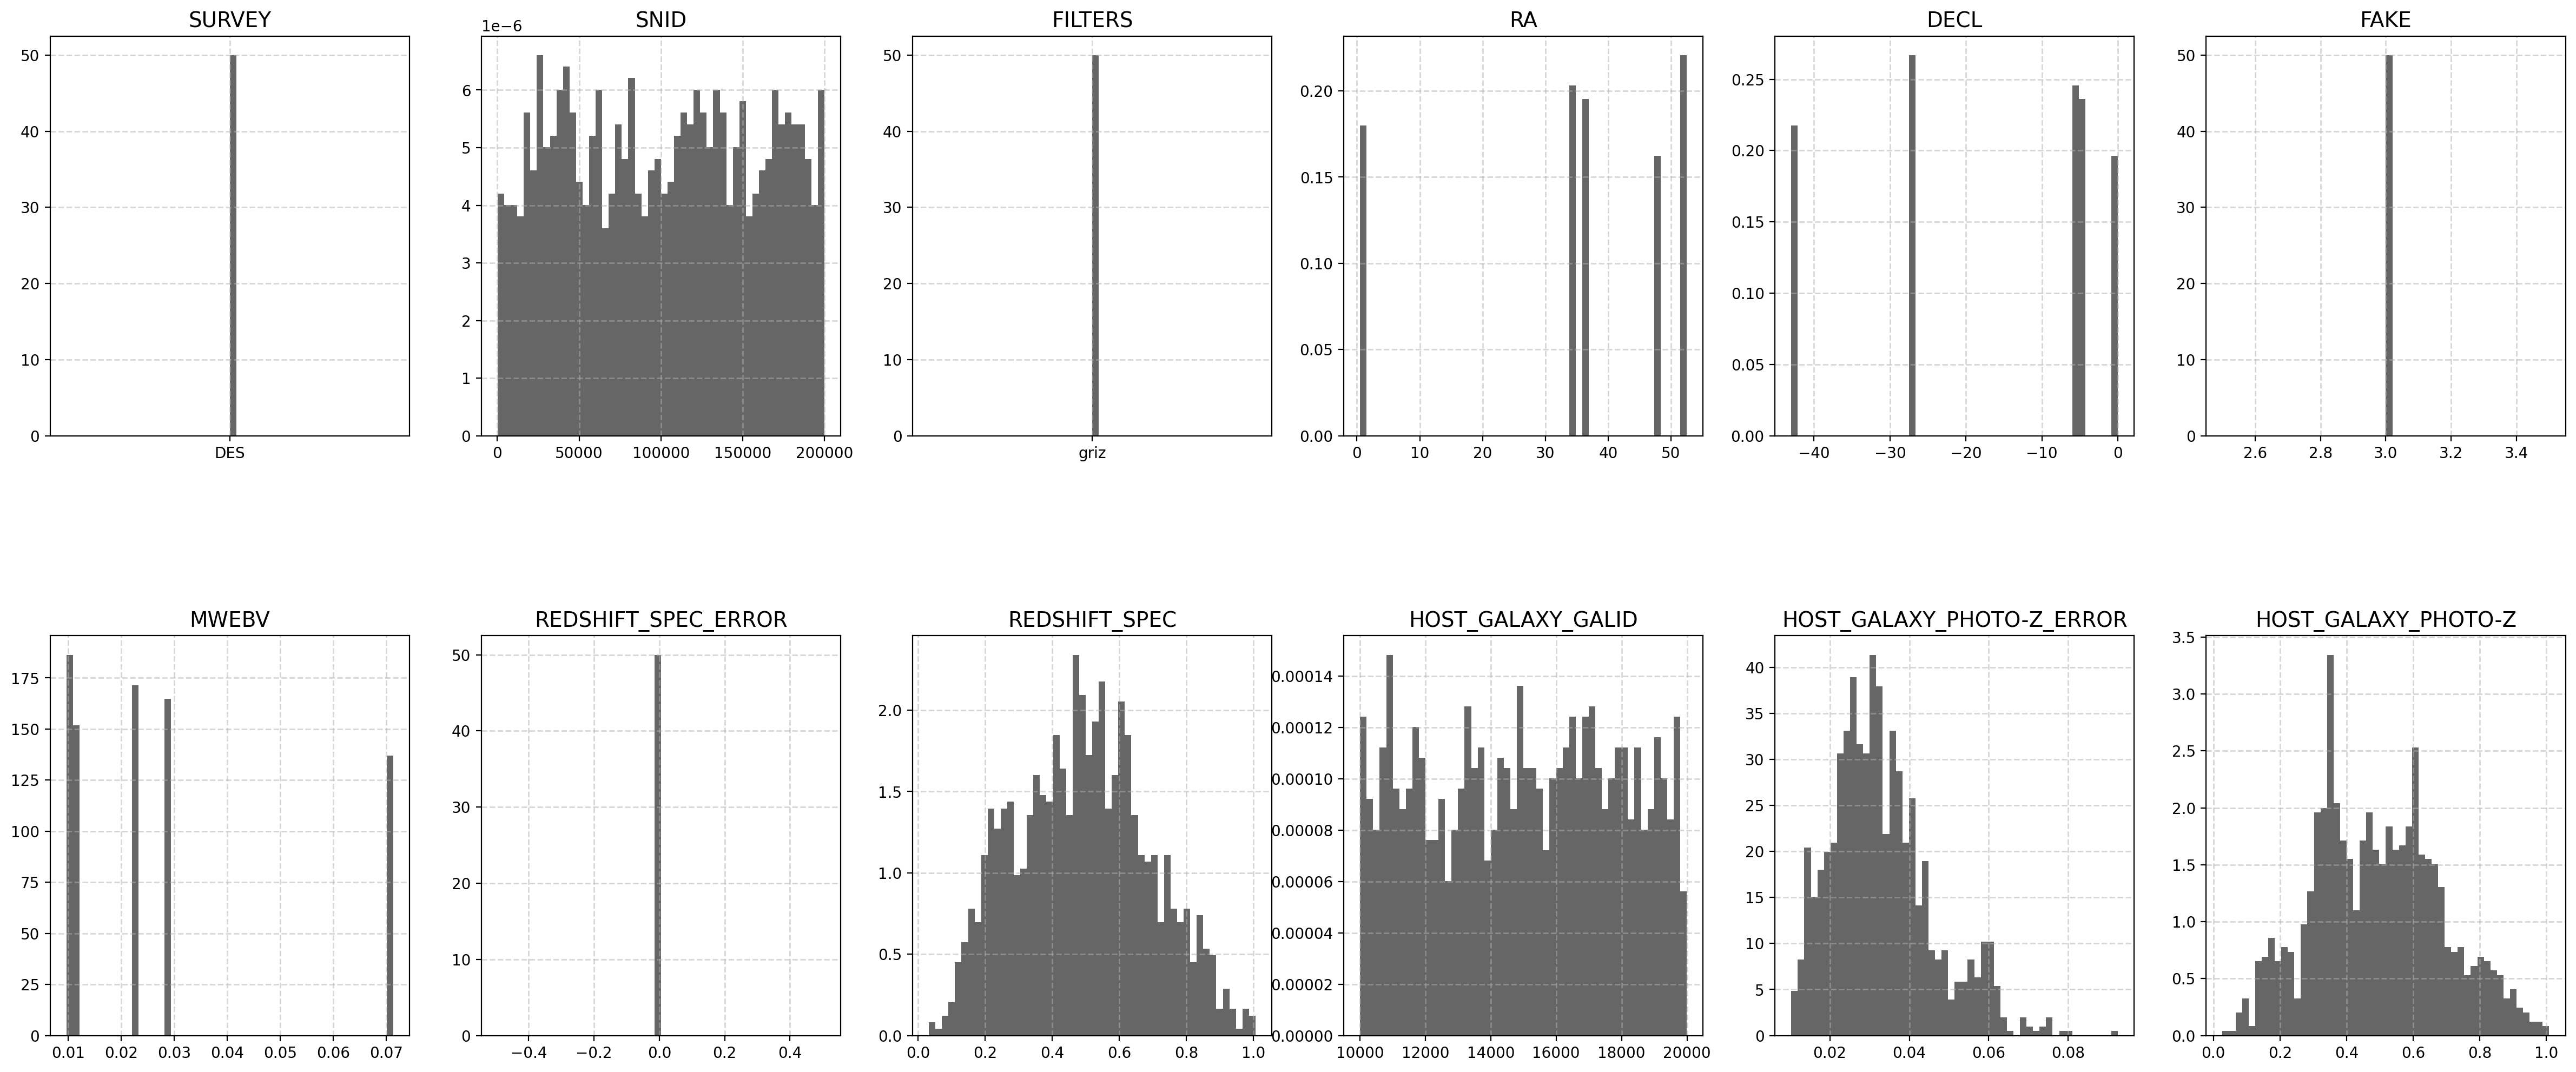

In [3]:
# Define the number of rows and columns for the subplots
n_rows = 2
n_cols = 6
# Adapt the figure size to the number of subplots
plt.figure(figsize=(n_cols*5, n_rows*6))
# Loop over the rows and columns to plot the histograms
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.hist(X[other_pars[index]], bins=50, density=True, color='#666666')
        plt.grid(True, alpha=0.5, linestyle='--', linewidth=1)
        plt.title(other_pars[index], fontsize=14)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show();

From this graph, we observe that the parameters `SURVEY`, `FILTERS`, `FAKE` and `REDSHIFT_SPEC_ERROR` have apparently single-value distributions. Let us check and, if necessary, remove these parameters.

In [4]:
# Count the values of *SURVEY*, *FILTERS*, *FAKE* and *REDSHIFT_SPEC_ERROR*
print(X['SURVEY'].value_counts())
print('\n')
print(X['FILTERS'].value_counts())
print('\n')
print(X['FAKE'].value_counts())
print('\n')
print(X['REDSHIFT_SPEC_ERROR'].value_counts())

SURVEY
DES    1250
Name: count, dtype: int64


FILTERS
griz    1250
Name: count, dtype: int64


FAKE
3.0    1250
Name: count, dtype: int64


REDSHIFT_SPEC_ERROR
0.005    1250
Name: count, dtype: int64


In [5]:
# Remove these parameters from the dataset X
X.drop(['SURVEY', 'FILTERS', 'FAKE', 'REDSHIFT_SPEC_ERROR'], axis=1, inplace=True)
# Remove them from the other_pars array
other_pars = np.array([col for col in other_pars if col not in ['SURVEY', 'FILTERS', 'FAKE', 'REDSHIFT_SPEC_ERROR']])

`RA`, `DECL`, `MWEBV`, on the other hand, present distributions that seem to be discretised over a few values. Let us check and proceed accordingly.

In [6]:
# Count the values of *RA*, *DECL* and *MWEBV*
print(X['RA'].value_counts())
print('\n')
print(X['DECL'].value_counts())
print('\n')
print(X['MWEBV'].value_counts())

RA
52.50    287
34.50    264
36.75    254
0.50     234
48.00    211
Name: count, dtype: int64


DECL
-27.5    287
-5.5     264
-4.5     254
-43.0    234
 0.0     211
Name: count, dtype: int64


MWEBV
0.0097    287
0.0227    264
0.0283    254
0.0111    234
0.0713    211
Name: count, dtype: int64


We could then categorise these features using __one-hot encoding__, but in this case the nnumerical values are relevant, therefore we do not need any modification.

Finally, we note that the feature `SNID` is singular for each event: it is necessary to eliminate it to prevent a classification algorithm from learning it 'by heart', thus associating each training element with its ID.

In [7]:
# Drop the *SNID* column
X.drop('SNID', axis=1, inplace=True)
# Define the new other_pars array
other_pars = np.array([col for col in X.columns if col not in (lc_pars) and (col != 'SNTYPE')])

We can also repeat this procedure for light curve features. What we observe are continuous distributions, so no modifications are necessary.

#### __2. Correlation Matrix__
A __correlation matrix__ is a table that shows the correlation coefficients between many variables. Each cell in the table represents the correlation between two variables. The matrix is *symmetric* because the correlation is. In particular, we compute the correlation coefficient using the __Pearson coefficient__: a measure of the linear relationship between two variables.

- $ r = 1 $: Perfect positive linear correlation
- $ r = -1 $: Perfect negative linear correlation
- $ r = 0 $: No linear correlation

The formula for calculating the Pearson correlation coefficient between two variables, $ X $ and $ Y $, with $ n $ data points, is as follows:

$$ r = \frac{ \sum_{i=0}^{n}{(X_i - \bar{X})(Y_i - \bar{Y})} }{\sqrt{\sum_{i=0}^{n}{(X_i - \bar{X})^2}\sum_{i=0}^{n}{(Y_i - \bar{Y})^2}}} $$

where:
- $ X_i $ and $ Y_i $ are the individual data points for variables $ X $ and $ Y $.
- $ \bar{X} $ and $ \bar{Y} $ are the means of variables $ X $ and $ Y $, respectively.

Start with the numerical features from the so-called `other_parameters`.

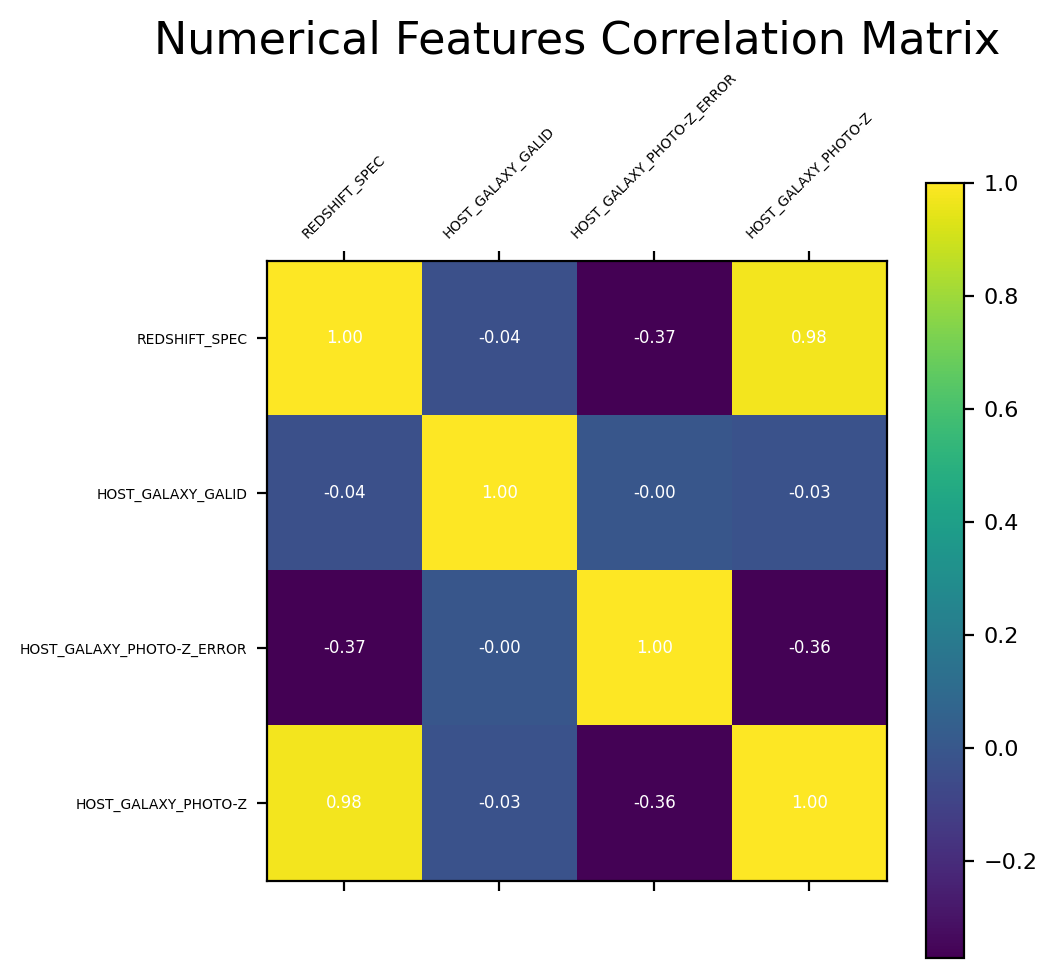

In [8]:
# Define numerical features from the other_pars array
num_features = ['REDSHIFT_SPEC', 'HOST_GALAXY_GALID', 'HOST_GALAXY_PHOTO-Z_ERROR', 'HOST_GALAXY_PHOTO-Z']

# Define the correlation matrix
corr_matrix = X[num_features].corr(method='pearson')
# Plot the correlation matrix
plt.figure(figsize=(5,5), num=2)
plt.matshow(corr_matrix, fignum=2)
plt.xticks(range(X[num_features].shape[1]), X[num_features].columns, 
           fontsize=5, rotation=45)
plt.yticks(range(X[num_features].shape[1]), X[num_features].columns, 
           fontsize=5)
# Fill each cell with the correlation value
for (i, j), z in np.ndenumerate(corr_matrix):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=6, color='w')
# Colorbar to identify the color representation of the correlation values
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Numerical Features Correlation Matrix', fontsize=16)
plt.show();

We observe an almost perfect positive correlation between the parameter `REDSHIFT_SPEC` and `HOST_GALAXY_PHOTO-Z`. This makes sense because the former is the SN-specific redshift, the latter refers to the reference galaxy.\
Since we already have many parameters and since `HOST_GALAXY_PHOTO-Z` has an error associated with the measurement, we remove `REDSHIFT_SPEC`.

In [9]:
# Remove *REDSHIFT_SPEC* from the other_pars array and from the dataset X
X.drop('REDSHIFT_SPEC', axis=1, inplace=True)
other_pars = np.array([col for col in other_pars if col != 'REDSHIFT_SPEC'])

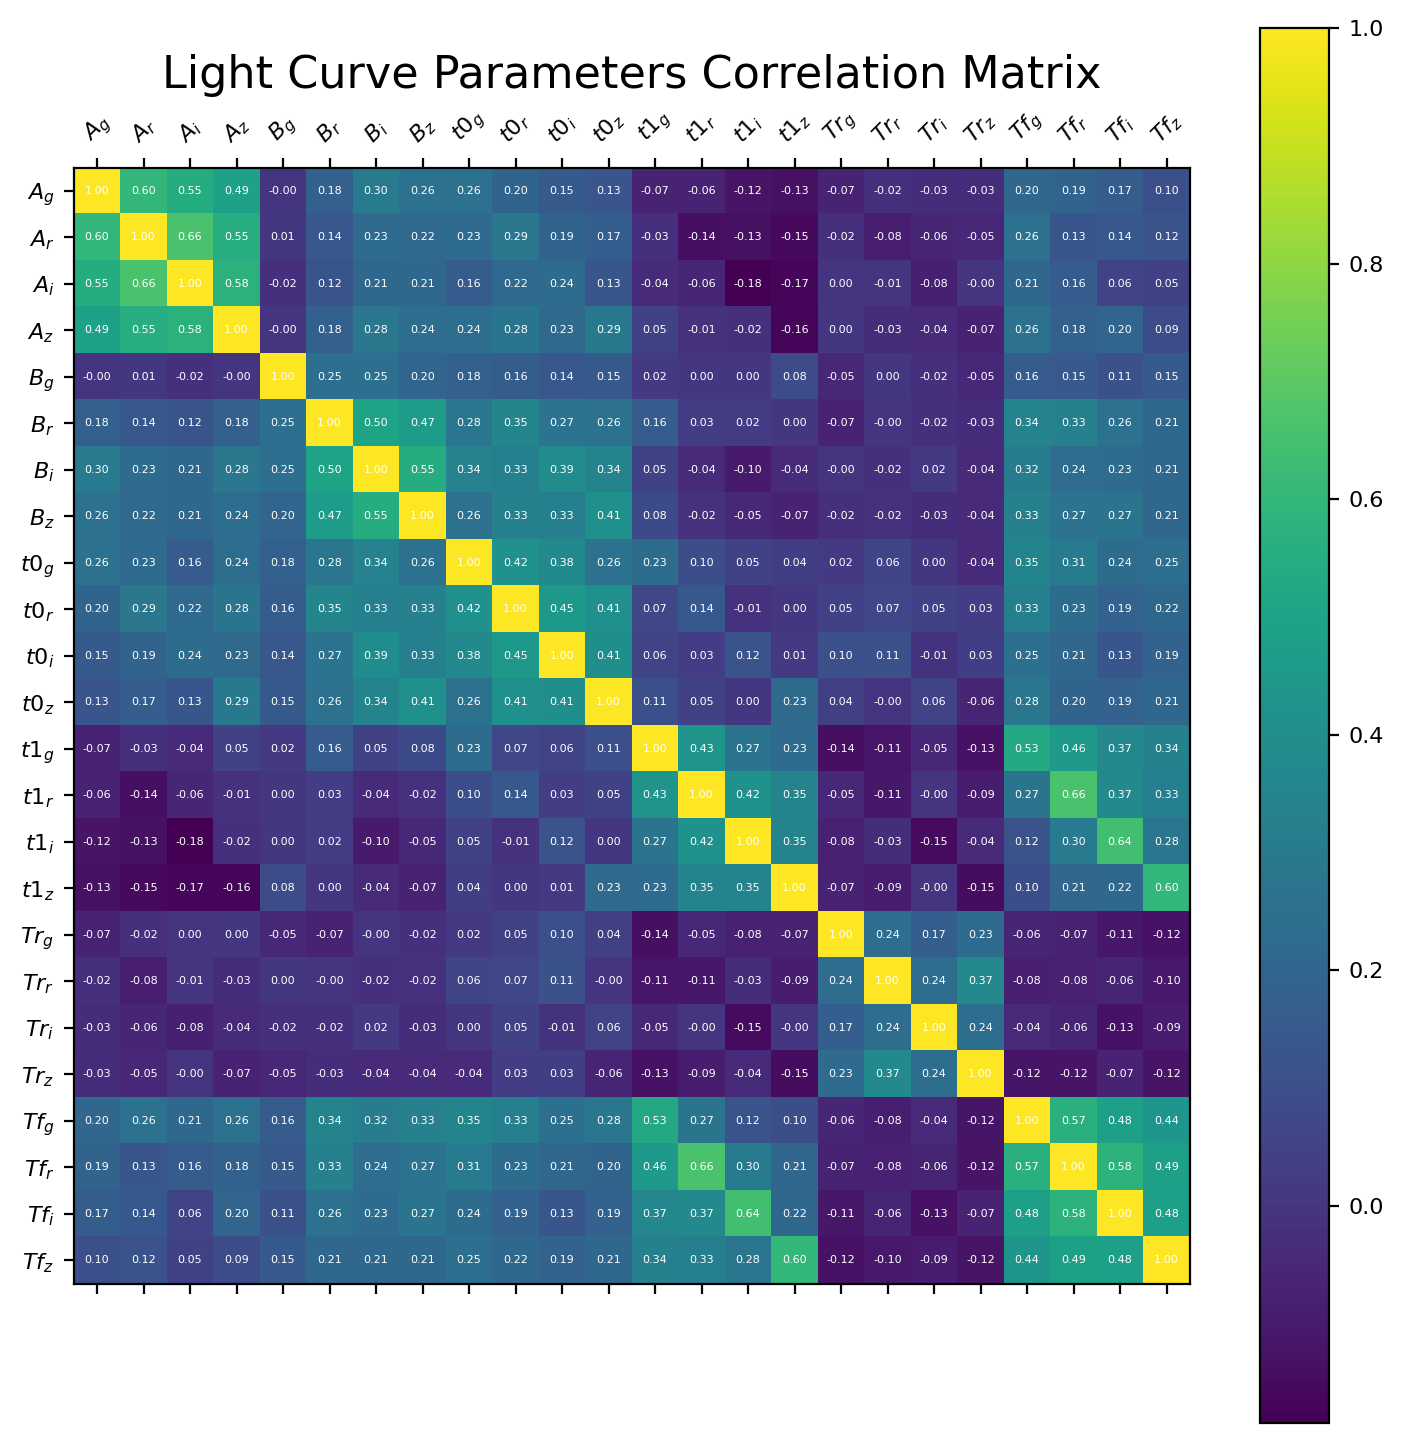

In [10]:
# Define the correlation matrix
corr_matrix = X[lc_pars].corr(method='pearson')
# Plot the correlation matrix
plt.figure(figsize=(9,9), num=2)
plt.matshow(corr_matrix, fignum=2)
plt.xticks(range(X[lc_pars].shape[1]), '$'+X[lc_pars].columns+'$', 
           fontsize=8, rotation=45)
plt.yticks(range(X[lc_pars].shape[1]), '$'+X[lc_pars].columns+'$', 
           fontsize=8)
# Fill each cell with the correlation value
for (i, j), z in np.ndenumerate(corr_matrix):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=4, color='w')
# Colorbar to identify the color representation of the correlation values
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Light Curve Parameters Correlation Matrix', fontsize=16)
plt.show();

In this last correlation matrix, beyond the individual values that can be observed, a square structure can be seen: these squares have a side equal to $4$ and represent the subgroups referring to the same parameter (with different filters).\
Brighter squares (*higher* positive correlation) are observed under the following conditions: 
- when it is the same subgroup: i.e. the same parameter, in different filters, shows positive correlation,
- when dealing with the parameters $T_f$ and $t_1$, which present correlation up to $0.68$.

In general, no values, either positive or negative, are observed that would justify the removal of one or more parameters.

#### __3. Data Standardization__
We now want to transform the features of the the dataset to a standard scale. We do this *before* splitting the dataset so that we will not need to do it again at testing level.\
We apply:

1. **Z-score Normalization** (Zero-mean normalization):
   - For each feature, calculate the mean ($\mu$) and standard deviation ($\sigma$).
   - Standardize each data point ($x$) in the feature using the formula: $\frac{x - \mu}{\sigma}$.
   - Resulting data points will have a mean of 0 and a standard deviation of 1.

2. **Min-Max Scaling:**
   - For each feature, calculate the minimum ($min$) and maximum ($max$) values.
   - Scale each data point ($x$) in the feature using the formula: $\frac{x - min}{max - min}$.

For us, data standardization is important for 2 main reasons:

- **Algorithms Sensitivity:** many machine learning algorithms, such as *k-means clustering* are sensitive to the scale of input features. Standardization helps ensure that no single feature dominates the others.

- **Convergence Speed:** algorithms that involve gradient descent converge faster when the features are on a similar scale.

__ATTENTION__: before proceeding, however, we must note how this procedure can have an impact on the relationship between a measurement feature and its error. In the process of sdandardisation, the measurement and its error are modified with respect to different scales: this means that the relationship (or, equivalently, the relative error) is modified. We must therefore create a new feature representing the relative error and, only then, standardise it.

In [11]:
# Create a new column named *HOST_GALAXY_PHOTO-Z_ERROR* with the values of *HOST_GALAXY_PHOTO-Z_ERROR* 
# divided by *HOST_GALAXY_PHOTO-Z*
X['HOST_GALAXY_PHOTO-Z_ERROR'] = X['HOST_GALAXY_PHOTO-Z_ERROR']/X['HOST_GALAXY_PHOTO-Z']

In [12]:
# Use scikit-learn's StandardScaler to scale all the non-categorical features (avoiding the *SNID* column)
import sklearn
from sklearn.preprocessing import StandardScaler
# Define the scaler and use zero mean normalization
scaler = StandardScaler(with_mean=True, with_std=True)
# Scale the numerical features
X_scaled = scaler.fit_transform(X[X.columns[1:]])

# Define the new dataframe with the scaled numerical features
X_scaled = pd.DataFrame(X_scaled, columns=X.columns[1:])
# Add the *SNID* column to the scaled dataframe
X_scaled['SNTYPE'] = X['SNTYPE']

In [13]:
# Associate the SNTYPE values to the corresponding supernova type
X_scaled['SNTYPE'] = X_scaled['SNTYPE'].map({1:'Ia', 21:'IIn', 22:'IIP', 23:'IIL', 3:'Ibc', 32:'Ib', 33:'Ic'})

### __4. Splitting__
Finally, __split__ the dataset into a training and a testing subset. We use a ratio of $0.2$. \
As can be seen in the cell below, we do not have many training points (only $1000$, with many features each), so we need to find a way to optimise the learning from our dataset.

In [14]:
# Use scikit-learn to split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X_scaled, test_size=0.2, shuffle=False, random_state=42)
# Define the training and testing labels
y_train = X_train['SNTYPE']
y_test = X_test['SNTYPE']
# Remove the labels from the training and testing sets
X_train.drop('SNTYPE', axis=1, inplace=True)
X_test.drop('SNTYPE', axis=1, inplace=True)

# Display the length of the training and testing sets
print(f'Training set has {X_train.shape[0]} samples.')
print(f'Testing set has {X_test.shape[0]} samples.')

Training set has 1000 samples.
Testing set has 250 samples.


At this point, we end up with a training set with $1000$ SN data points (SN events), each consisting of $30$ numerical features.
Similarly, we have $250$ points for the test set.

In [15]:
# Take a look at the training set
X_train.iloc[:5]

,RA,DECL,MWEBV,HOST_GALAXY_GALID,HOST_GALAXY_PHOTO-Z_ERROR,HOST_GALAXY_PHOTO-Z,A_g,B_g,t0_g,t1_g,...,t0_i,t1_i,Tr_i,Tf_i,A_z,B_z,t0_z,t1_z,Tr_z,Tf_z
0,0.097251,0.740447,0.066576,0.656752,-0.398798,0.375983,-0.441852,-0.597448,-0.709408,-0.890395,...,-0.515247,-1.000855,-0.318692,-0.773696,-0.086137,-0.291424,-0.083487,0.785757,-0.261065,-0.030239
1,0.097251,0.740447,0.066576,0.629963,0.019984,-0.864108,0.814053,-0.600688,-0.416627,-0.298089,...,-0.859539,-1.000855,3.724536,-0.513283,-0.102220,-0.291104,-0.672335,-0.736385,-0.360645,-0.519133
2,0.097251,0.740447,0.066576,0.011049,-0.420628,0.511002,-0.488784,0.091116,0.374829,-0.567838,...,0.231194,-0.215331,-0.348553,-0.950315,-0.755338,-0.277996,-0.886874,-0.974247,3.538478,-0.852801
3,0.974512,-0.685922,-0.808733,-1.432737,-0.313891,0.364039,-0.258120,-0.596187,0.048216,-0.127508,...,-0.399475,-1.000855,-0.279508,-0.784776,-0.588635,-0.291420,-0.261010,1.883560,-0.256121,1.625818
4,-0.028072,0.678431,-0.196958,-0.611345,-0.791865,2.353483,-0.453351,-0.580503,3.305443,2.515050,...,-0.032618,1.854619,-0.199513,1.584974,-0.487607,-0.291366,0.031749,0.379442,-0.263325,1.092053


In [16]:
# At the end, save the training and testing sets to csv files
X_train.to_csv('final_datasets/X_train.csv', index=False)
X_test.to_csv('final_datasets/X_test.csv', index=False)
y_train.to_csv('final_datasets/y_train.csv', index=False)
y_test.to_csv('final_datasets/y_test.csv', index=False)